In [1]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
from trainingUtils import  compute_kernel, compute_mmd
from models import Encoder,Decoder,VAE
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

import json

import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

# Load data

In [4]:
# Load cmap
cmap = pd.read_csv('../data/cmap_gex_shrna_q1replicates.csv',index_col=0)
gene_size = len(cmap.columns)

# Training and validation

In [3]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [5]:
from math import floor
NUM_EPOCHS = 20
bs = 256
latent_dim = 1024

In [12]:
valR2 = []
valPear = []
valMSE =[]
valCorrLatent = []
trainPear = []
trainSpear = []
valSpear = []
trainAccuracy = []
valAccuracy = []

for i in range(10):
    # Network
    encoder = Encoder(gene_size,[4096,2048],latent_dim,dropRate=0.25, activation=torch.nn.ELU())
    decoder = Decoder(latent_dim,[2048,4096],gene_size,dropRate=0.1, activation=torch.nn.ELU())
    autoencoder = VAE(encoder,decoder).to(device)
    
    
    index = pd.read_csv('crossval/valIndex_%s.csv'%i,index_col=0)
    cmap_val = cmap.loc[index.ind,:]
    cmap_train = cmap.drop(cmap_val.index)
    
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr= 0.0001, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.8)
    
    N = len(cmap_train)
    
    for e in range(0, NUM_EPOCHS):
        
        trainloader = getSamples(N, bs)
        for dataIndex in trainloader:
            autoencoder.train()
            optimizer.zero_grad()
            X = torch.tensor(cmap_train.iloc[dataIndex,:].values).float().to(device)
            z_latent , y_pred = autoencoder(X)
            true_samples = torch.autograd.Variable(torch.randn(z_latent.shape[0], z_latent.shape[1]), requires_grad=False)
            true_samples = true_samples.to(device)
            fitLoss = torch.mean(torch.sum((y_pred - X)**2,dim=1))+ compute_mmd(true_samples,z_latent)
            L2Loss = autoencoder.L2Regularization(0.01)
            loss = fitLoss + L2Loss

            loss.backward()

            optimizer.step()
        
            pearson = pearson_r(X.detach(),y_pred.detach())
            r2 = r_square(y_pred.detach().flatten(), X.detach().flatten())
            mse = torch.mean(torch.mean((y_pred.detach() - X.detach())**2,dim=1))
              
            outString = 'Split {:.0f}/{:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,10,e+1,NUM_EPOCHS)
            outString += ', r2={:.4f}'.format(r2.item())
            outString += ', pearson={:.4f}'.format(pearson.item())
            outString += ', MSE={:.4f}'.format(mse.item())
            outString += ', loss={:.4f}'.format(loss.item())
            
        print(outString)
        scheduler.step()
    autoencoder.eval()
        
    yhat = torch.zeros(len(cmap_train),gene_size)
    y = torch.tensor(cmap_train.values).float()
    for dataIndex in trainloader:
        X = torch.tensor(cmap_train.iloc[dataIndex,:].values).float().to(device)
        z_latent , y_pred = autoencoder(X)
        yhat[dataIndex,:] = y_pred.detach().cpu()
    pearson = pearson_r(y,yhat)
    print('Training pearson: %s'%pearson.item())
    trainPear.append(pearson.item())
    rhos =[]
    for jj in range(y.shape[0]):
        rho,p = spearmanr(y[jj,:].numpy(),yhat[jj,:].numpy())
        rhos.append(rho)
    print('Training spearman: %s'%np.mean(rhos))
    trainSpear.append(np.mean(rhos))
    trainacc = pseudoAccuracy(y.detach().cpu(),yhat.detach().cpu(),eps=1e-4)
    print('Pseudo-Accuracy: %s'%np.mean(trainacc))
    trainAccuracy.append(trainacc)
        
    X_val = torch.tensor(cmap_val.values).float().to(device)
    zval , yval = autoencoder(X_val)
    valpear = pearson_r(X_val.detach().cpu(),yval.detach().cpu()).detach()
    valr2 = r_square(yval.detach().cpu().flatten(), X_val.detach().cpu().flatten())
    valmse = torch.mean(torch.mean((yval.detach().cpu() - X_val.detach().cpu())**2,dim=1))
    rhos =[]
    for jj in range(yval.shape[0]):
        rho,p = spearmanr(X_val[jj,:].detach().cpu().numpy(),yval[jj,:].detach().cpu().numpy())
        rhos.append(rho)
        
    valR2.append(valr2.item())
    valPear.append(valpear.item())
    valMSE.append(valmse.item())
    valSpear.append(np.mean(rhos))
    valacc = pseudoAccuracy(X_val.detach().cpu(),yval.detach().cpu(),eps=1e-4)
    valAccuracy.append(valacc)
    
    print('Pearson of validation: %s'%valpear.item())
    print('Spearmanof validation: %s'%np.mean(rhos))
    print('R2 of validation: %s'%valr2.item())
    print('MSE of validation: %s'%valmse.item())
    print('Pseudo-Accuracy: %s'%np.mean(valacc))
    torch.save(autoencoder,'crossval/trained_models/autoencoder%s.pt'%i)

Split 10/10: Epoch=1/20, r2=-0.9245, pearson=0.4878, MSE=0.4130, loss=4291.9604
Split 10/10: Epoch=2/20, r2=-0.3913, pearson=0.6172, MSE=0.3394, loss=3548.6970
Split 10/10: Epoch=3/20, r2=-0.0894, pearson=0.7121, MSE=0.2940, loss=3090.6218
Split 10/10: Epoch=4/20, r2=0.2659, pearson=0.7387, MSE=0.2635, loss=2782.7192
Split 10/10: Epoch=5/20, r2=0.3624, pearson=0.7754, MSE=0.2390, loss=2534.8323
Split 10/10: Epoch=6/20, r2=0.3803, pearson=0.7840, MSE=0.2246, loss=2388.8435
Split 10/10: Epoch=7/20, r2=0.4293, pearson=0.8039, MSE=0.2192, loss=2333.5569
Split 10/10: Epoch=8/20, r2=0.5594, pearson=0.8106, MSE=0.2229, loss=2370.3518
Split 10/10: Epoch=9/20, r2=0.4944, pearson=0.8119, MSE=0.2006, loss=2144.8660
Split 10/10: Epoch=10/20, r2=0.4906, pearson=0.8165, MSE=0.1896, loss=2033.1858
Split 10/10: Epoch=11/20, r2=0.5180, pearson=0.8306, MSE=0.1886, loss=2022.3926
Split 10/10: Epoch=12/20, r2=0.5317, pearson=0.8287, MSE=0.1774, loss=1908.4590
Split 10/10: Epoch=13/20, r2=0.5968, pearson=0

# Evaluate models

In [11]:
valR2 = []
valPear = []
valMSE =[]
valCorrLatent = []
trainPear = []
trainSpear = []
valSpear = []
trainAccuracy = []
valAccuracy = []

for i in range(10):
    # Network
    autoencoder = torch.load('crossval/trained_models/autoencoder%s.pt'%i)
    
    index = pd.read_csv('crossval/valIndex_%s.csv'%i,index_col=0)
    cmap_val = cmap.loc[index.ind,:]
    cmap_train = cmap.drop(cmap_val.index)    
    
    N = len(cmap_train)
    trainloader = getSamples(N, bs)
    autoencoder.eval()
    
    yhat = torch.zeros(len(cmap_train),gene_size)
    y = torch.tensor(cmap_train.values).float()
    for dataIndex in trainloader:
        X = torch.tensor(cmap_train.iloc[dataIndex,:].values).float().to(device)
        z_latent , y_pred = autoencoder(X)
        yhat[dataIndex,:] = y_pred.detach().cpu()
    pearson = pearson_r(y,yhat)
    print('Training pearson: %s'%pearson.item())
    trainPear.append(pearson.item())
    rhos =[]
    for jj in range(y.shape[0]):
        rho,p = spearmanr(y[jj,:].numpy(),yhat[jj,:].numpy())
        rhos.append(rho)
    print('Training spearman: %s'%np.mean(rhos))
    trainSpear.append(np.mean(rhos))
    trainacc = pseudoAccuracy(y.detach().cpu(),yhat.detach().cpu(),eps=1e-4)
    print('Pseudo-Accuracy: %s'%np.mean(trainacc))
    trainAccuracy.append(trainacc)
        
    X_val = torch.tensor(cmap_val.values).float().to(device)
    zval , yval = autoencoder(X_val)
    valpear = pearson_r(X_val.detach().cpu(),yval.detach().cpu()).detach()
    valr2 = r_square(yval.detach().cpu().flatten(), X_val.detach().cpu().flatten())
    valmse = torch.mean(torch.mean((yval.detach().cpu() - X_val.detach().cpu())**2,dim=1))
    rhos =[]
    for jj in range(yval.shape[0]):
        rho,p = spearmanr(X_val[jj,:].detach().cpu().numpy(),yval[jj,:].detach().cpu().numpy())
        rhos.append(rho)
        
    valR2.append(valr2.item())
    valPear.append(valpear.item())
    valMSE.append(valmse.item())
    valSpear.append(np.mean(rhos))
    valacc = pseudoAccuracy(X_val.detach().cpu(),yval.detach().cpu(),eps=1e-4)
    valAccuracy.append(valacc)
    
    print('Pearson of validation: %s'%valpear.item())
    print('Spearmanof validation: %s'%np.mean(rhos))
    print('R2 of validation: %s'%valr2.item())
    print('MSE of validation: %s'%valmse.item())
    print('Pseudo-Accuracy: %s'%np.mean(valacc))

Training pearson: 0.900650680065155
Training spearman: 0.8877668524445544
Pseudo-Accuracy: 0.8632525214098224
Pearson of validation: 0.893596887588501
Spearmanof validation: 0.878624876497474
R2 of validation: 0.6564831137657166
MSE of validation: 0.12605983018875122
Pseudo-Accuracy: 0.8566610047290977
Training pearson: 0.899837076663971
Training spearman: 0.8873058481825302
Pseudo-Accuracy: 0.8630862474747568
Pearson of validation: 0.9023279547691345
Spearmanof validation: 0.8909611839071389
R2 of validation: 0.726855993270874
MSE of validation: 0.11933166533708572
Pseudo-Accuracy: 0.8659251335685746
Training pearson: 0.9005655646324158
Training spearman: 0.8867304682682146
Pseudo-Accuracy: 0.862334412826261
Pearson of validation: 0.9046695232391357
Spearmanof validation: 0.8919178763904638
R2 of validation: 0.7160160541534424
MSE of validation: 0.11836344748735428
Pseudo-Accuracy: 0.8663431309565724
Training pearson: 0.8475398421287537
Training spearman: 0.8286170146193139
Pseudo-Acc

In [14]:
trainResults = pd.DataFrame({'pearson':trainPear,
                             'spearman':trainSpear,
                             'Accuracy':np.mean(trainAccuracy,axis=1),
                             'set':['train' for i in range(10)]})
trainResults

,pearson,spearman,Accuracy,set
0,0.900651,0.887767,0.863253,train
1,0.899837,0.887306,0.863086,train
2,0.900566,0.886730,0.862334,train
3,0.847540,0.828617,0.827758,train
4,0.899413,0.886620,0.862599,train
5,0.900066,0.887572,0.863349,train
6,0.899860,0.886937,0.862698,train
7,0.900449,0.887898,0.863671,train
8,0.901796,0.888174,0.863650,train
9,0.902434,0.889937,0.864871,train


In [15]:
valResults = pd.DataFrame({'pearson':valPear,
                             'spearman':valSpear,
                             'Accuracy':np.mean(valAccuracy,axis=1),
                             'set':['validation' for i in range(10)]})
valResults

,pearson,spearman,Accuracy,set
0,0.893597,0.878625,0.856661,validation
1,0.902328,0.890961,0.865925,validation
2,0.904670,0.891918,0.866343,validation
3,0.853757,0.837321,0.833921,validation
4,0.900620,0.889600,0.865418,validation
5,0.894881,0.881797,0.859941,validation
6,0.893806,0.880115,0.858425,validation
7,0.882375,0.868663,0.850364,validation
8,0.876851,0.861333,0.845496,validation
9,0.888581,0.876224,0.855470,validation


In [16]:
results = pd.concat([trainResults,valResults],axis=0)
results

,pearson,spearman,Accuracy,set
0,0.900651,0.887767,0.863253,train
1,0.899837,0.887306,0.863086,train
2,0.900566,0.886730,0.862334,train
3,0.847540,0.828617,0.827758,train
4,0.899413,0.886620,0.862599,train
5,0.900066,0.887572,0.863349,train
6,0.899860,0.886937,0.862698,train
7,0.900449,0.887898,0.863671,train
8,0.901796,0.888174,0.863650,train
9,0.902434,0.889937,0.864871,train


In [18]:
results.to_csv('crossval/performance/10fold_validation_results.csv')

# Visualize results

In [9]:
results = pd.read_csv('crossval/performance/10fold_validation_results.csv',index_col=0)

In [10]:
results = pd.melt(results[['pearson','spearman','set']],id_vars=['set'])

In [20]:
results.columns = ['set','metric','value']

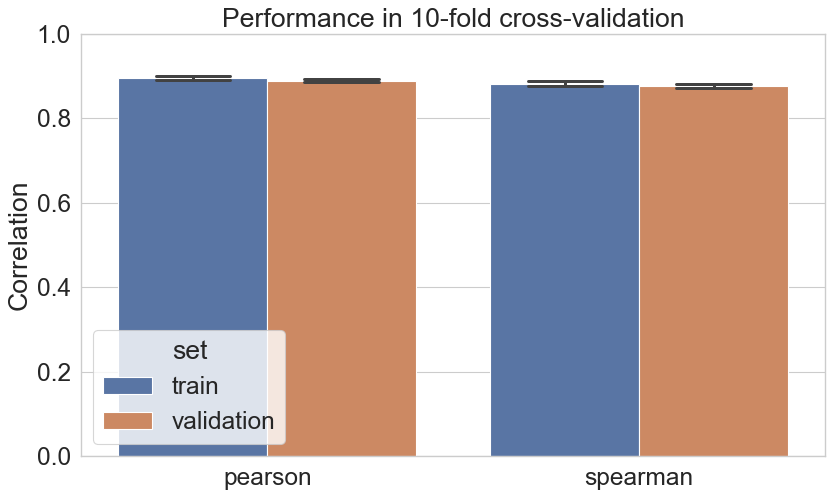

In [26]:
sns.set_theme(style="whitegrid",font_scale = 2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="metric", y="value", data=results,
            order=['pearson','spearman'],
            hue="set",ci=68,capsize=0.2)
plt.gca().set(title='Performance in 10-fold cross-validation', 
              xlabel = '',
              ylabel='Correlation')
plt.ylim(0,1.0)
plt.savefig('10fold_validation_vae_shrna.png', bbox_inches='tight',dpi=600)

# Train one model and get embeddings

In [10]:
# Create a generator to predict in batches
def getBatches(N, batchSize):
    order = np.arange(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [17]:
encoder = Encoder(gene_size,[4096,2048],latent_dim,dropRate=0.25, activation=torch.nn.ELU())
decoder = Decoder(latent_dim,[2048,4096],gene_size,dropRate=0.1, activation=torch.nn.ELU())
autoencoder = VAE(encoder,decoder).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr= 0.0001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.8)
    
N = len(cmap)
    
for e in range(0, NUM_EPOCHS):
    trainloader = getSamples(N, bs)
    for dataIndex in trainloader:
        autoencoder.train()
        optimizer.zero_grad()
        X = torch.tensor(cmap.iloc[dataIndex,:].values).float().to(device)
        z_latent , y_pred = autoencoder(X)
        true_samples = torch.autograd.Variable(torch.randn(z_latent.shape[0], z_latent.shape[1]), requires_grad=False)
        true_samples = true_samples.to(device)
        fitLoss = torch.mean(torch.sum((y_pred - X)**2,dim=1))+ compute_mmd(true_samples,z_latent)
        L2Loss = autoencoder.L2Regularization(0.01)
        loss = fitLoss + L2Loss

        loss.backward()

        optimizer.step()
        
        pearson = pearson_r(X.detach(),y_pred.detach())
        r2 = r_square(y_pred.detach().flatten(), X.detach().flatten())
        mse = torch.mean(torch.mean((y_pred.detach() - X.detach())**2,dim=1))
              
        outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
        outString += ', r2={:.4f}'.format(r2.item())
        outString += ', pearson={:.4f}'.format(pearson.item())
        outString += ', MSE={:.4f}'.format(mse.item())
        outString += ', loss={:.4f}'.format(loss.item())
        print(outString)
        clear_output(wait=True)
    scheduler.step()

autoencoder.eval()
        
yhat = torch.zeros(len(cmap),gene_size)
y = torch.tensor(cmap.values).float()
z = torch.zeros(len(cmap),latent_dim)
predictloader = getBatches(N, bs)
for dataIndex in predictloader:
    X = torch.tensor(cmap.iloc[dataIndex,:].values).float().to(device)
    z_latent , y_pred = autoencoder(X)
    yhat[dataIndex,:] = y_pred.detach().cpu()
    z[dataIndex,:] = z_latent.detach().cpu()
torch.save(autoencoder,'autoencoder.pt')

Epoch=20/20, r2=0.6821, pearson=0.8404, MSE=0.2136, loss=2263.7915


In [22]:
pearson = pearson_r(y,yhat)
print(pearson)

tensor(0.8999)


<Figure size 720x480 with 0 Axes>

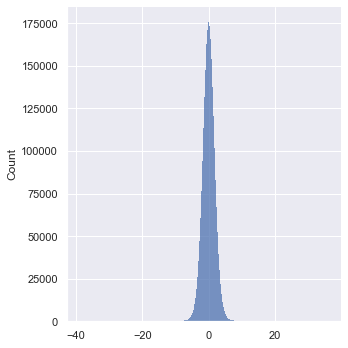

In [18]:
plt.figure(figsize=(9,6), dpi= 80)
sns.displot(z.flatten().numpy())
plt.savefig('vae_shrna_embs1024_distribution.png', bbox_inches='tight',dpi=600)

In [23]:
#Save embeddings
emb = pd.DataFrame(z.numpy())
emb.index = cmap.index
emb

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
TAK003_PC3_96H:TRCN0000245327:-666,0.273754,-0.716202,-0.469636,2.831640,0.919162,-2.727583,-1.106016,1.033613,-1.176306,2.531184,...,3.616142,0.455501,0.219920,2.332730,-0.182707,-1.429789,0.324040,0.756273,-0.317700,0.738249
DER001_A375_96H:TRCN0000001403:-666,1.749784,-1.709463,0.353584,0.365361,1.587645,-0.385361,1.934749,2.231980,0.902632,-1.487582,...,-0.216813,-2.945355,0.787738,1.564412,0.345724,0.047951,-0.333858,-0.722093,3.936314,1.106877
DER001_A375_96H:TRCN0000129908:-666,-3.073522,-1.115963,-0.229690,0.555705,-0.504200,0.356160,0.343024,-3.155095,0.747784,0.459834,...,1.435225,-1.228508,0.783978,-1.150898,-0.439236,0.888496,0.020350,-2.667249,-2.829118,0.755031
DER001_VCAP_96H:TRCN0000377572:-666,-1.674803,1.811689,0.739409,0.578418,-1.047165,-0.079250,-1.761610,-0.155354,-0.321837,-3.408151,...,-1.516917,2.274788,1.208191,-2.154344,-0.762699,-1.835119,-0.165088,1.452973,1.553637,-1.645348
DER001_VCAP_96H:TRCN0000131190:-666,1.726539,-2.513667,-0.524055,1.295838,0.671537,-1.653739,-2.620852,-1.854578,1.297677,1.761204,...,-0.314510,2.045749,-3.233829,-0.931707,-2.184738,4.885353,-2.796714,-2.470038,-2.496017,-0.009721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERGK016_VCAP_120H:TRCN0000001586:-666,0.625866,1.096736,-0.370932,0.367252,1.623174,-0.964121,-0.923268,1.523238,1.523104,0.835139,...,-0.627247,-0.110808,0.314777,0.253579,-2.498334,0.112823,-2.328271,-1.362716,0.840762,-0.606789
ERGK005_VCAP_120H:TRCN0000006197:-666,0.070255,1.708435,-0.848768,-0.743280,0.066953,-0.748502,1.329583,-0.412575,-0.910235,-0.311420,...,-0.537275,1.134939,-0.662957,0.678804,-1.196102,-1.193522,0.768796,1.366220,2.981124,-0.112420
ERGK005_VCAP_120H:TRCN0000196810:-666,0.752837,-1.620024,0.858303,0.999035,-1.295363,2.347986,3.949724,0.778747,0.856921,-1.845478,...,2.387659,-0.826307,1.021704,1.271336,-1.874273,1.907124,-0.209517,3.278048,0.954733,1.784732
ERGK011_VCAP_120H:TRCN0000196976:-666,0.893261,0.786771,0.465706,0.510612,0.284799,-1.744895,-0.903026,2.148978,0.591477,1.248112,...,0.341339,0.539999,-1.548622,0.960746,-1.400653,0.171623,1.073480,-0.493614,-0.679682,-0.755174


In [24]:
emb.to_csv('shrna_embs1024.csv')